In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
import os 
import datetime
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt

from keras import models, layers, optimizers
from keras.layers import Dense, Flatten, AveragePooling2D
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from resnet_common import ResNet50V2

In [3]:
# Set up the GPU to avoid the runtime error: Could not create cuDNN handle...
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# Give the arguments for the conv_base
conv_base = ResNet50V2(include_top=None, weights='imagenet', input_tensor=None, 
                       input_shape=(224,224,3), pooling=None, num_classes=1000)

conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [5]:
# Add the self-defined classifier 
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D(name='avg_pool'))
# -model.add(layers.AveragePooling2D((2,2), padding='valid'))
model.add(layers.Dropout(0.6))
model.add(layers.Flatten())
model.add(layers.Dense(units=2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,568,898
Trainable params: 23,523,458
Non-trainable params: 45,440
_________________________________________________________________


In [6]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 174


In [7]:
# Freeze the conv_base 
conv_base.trainable = False

In [8]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 2


In [9]:
# Give the directory for train, validation and test sets. 
base_dir = '/home/mike/Documents/keras_resnet_common/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
        
        
# Train the given datasets 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
# Finetune the last fully connected layers(the inception_c block)
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'inception_c':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [11]:
# Compile the model with the small optimizer
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [12]:
# Start Tensorboard --logdir logs/fit
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callback_list = [tensorboard_callback]

In [13]:
# Train the fintuned model 
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=50,
                    callbacks=callback_list)

Epoch 1/30
100/100 [==============================] - 19s 190ms/step - loss: 1.1956 - acc: 0.4790 - val_loss: 0.8492 - val_acc: 0.5030
Epoch 2/30
100/100 [==============================] - 19s 186ms/step - loss: 1.1474 - acc: 0.5060 - val_loss: 0.8190 - val_acc: 0.4820
Epoch 3/30
100/100 [==============================] - 19s 188ms/step - loss: 1.1218 - acc: 0.4915 - val_loss: 0.7913 - val_acc: 0.4890
Epoch 4/30
100/100 [==============================] - 19s 189ms/step - loss: 1.0724 - acc: 0.4985 - val_loss: 0.7799 - val_acc: 0.5000
Epoch 5/30
100/100 [==============================] - 19s 186ms/step - loss: 1.0203 - acc: 0.4990 - val_loss: 0.7619 - val_acc: 0.5470
Epoch 6/30
100/100 [==============================] - 19s 188ms/step - loss: 1.0025 - acc: 0.5010 - val_loss: 0.7551 - val_acc: 0.5090
Epoch 7/30
100/100 [==============================] - 19s 187ms/step - loss: 0.9858 - acc: 0.4960 - val_loss: 0.7433 - val_acc: 0.5500
Epoch 8/30
100/100 [==============================] - 1

In [14]:
# Show the graph
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 4416), started 0:55:30 ago. (Use '!kill 4416' to kill it.)

In [15]:
# Save the trained weights 
model.save('resnet50_v2_weights_tf_cats_and_dogs_small.h5')

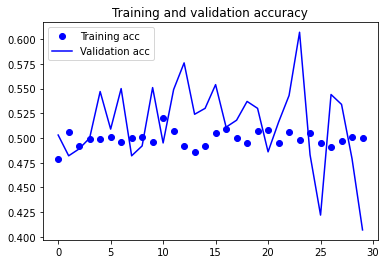

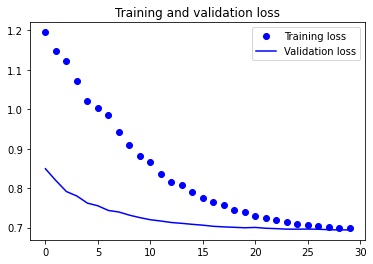

In [16]:
# Draw the general curves 
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

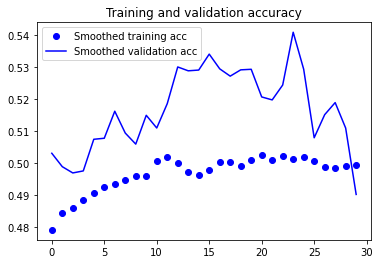

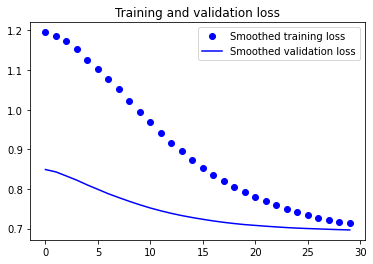

In [17]:
# Define the smooth curve function  
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Plot the smoothed curve 
plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
# Evaluate the fine-tuned model on the test data
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 2s 43ms/step - loss: 0.6940 - acc: 0.4450
test acc: 0.4449999928474426


In [19]:
# Release the GPU Memory
from numba import cuda

cuda.select_device(0)
cuda.close()